<a href="https://colab.research.google.com/github/Shujaat123/MUSI_Enhancement_TCMR_CNN/blob/main/MUSI_Enhancement_TCMR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Medical Ultrasound Image Speckle Reduction and Resolution Enhancement Using Texture Compensated Multi-Resolution Convolution Neural Network**
---

**loading required packages**

In [1]:
!pip install wget
import wget
import os
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array,  plot_model
import matplotlib.pyplot as plt
import numpy as np
import scipy
from PIL import Image
from numpy.random.mtrand import rayleigh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Loading a pre-trained model

In [2]:
model_path = 'https://raw.githubusercontent.com/Shujaat123/MUSI_Enhancement_TCMR_CNN/main/32_channel_3x3_MaxPool/32_channel_3x3_trial_0.h5'
model_file = 'model_weights.h5'
if (os.path.exists(model_file)):
  os.remove(model_file)
  wget.download(model_path, model_file)
else:
  wget.download(model_path, model_file)

model = load_model('model_weights.h5')
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True) # Uncomment to see model architecture

Loading sample input image


In [3]:
# FUNCTION FOR PREPARING NOISY-LOW-RESOLUTION SIMULATION
def prepare_sample(input_file,noise_level, blur_level):
  #####################-Loading SAMPLE IMAGE-#######################
  label_img = img_to_array(load_img(input_file, color_mode='grayscale'))

  ###################-Additing Rayleigh-Noise in clean image-#####################
  label_img = label_img/255.0
  input_img = label_img + noise_level* np.random.rayleigh(size=label_img.shape)

  ###############-Preparing a low-resolution noisy image-##################
  input_img = Image.fromarray(input_img.squeeze()).resize(size=(64, 64))
  input_img = Image.fromarray(np.array(input_img)).resize(size=(256, 256))

  input_img = scipy.ndimage.gaussian_filter(input_img, sigma = blur_level)
  input_img = np.clip(input_img, 0., 1.)
  input_img = np.expand_dims(np.array(input_img), axis = 2)
  input_img = np.expand_dims(input_img, axis = 0)

  #########-Filtering low-res-noisy image using Proposed network-##############
  output_img = model.predict(input_img, batch_size = 1)

  return label_img.squeeze(), input_img.squeeze(), output_img.squeeze()

####### FUNCTION FOR THE CALCULATION OF CONTRAST RECOVERY ################
def calculate_CR(label_img,input_img):
  mask1 = label_img
  mask2 = 1-label_img
  mean_lession = np.mean(input_img[mask1==1])
  mean_background = np.mean(input_img[mask2==1])
  var_lession = np.var(input_img[mask1==1])
  var_background = np.var(input_img[mask2==1])
  CR = np.abs(mean_lession-mean_background)
  return CR

In [4]:
#####################-DOWNLOADING SAMPLE IMAGE-#######################
input_img_path = 'https://raw.githubusercontent.com/Shujaat123/MUSI_Enhancement_TCMR_CNN/main/simulation_phantom.png'
input_file = 'input_img.png'
if (os.path.exists(input_file)):
  os.remove(input_file)
  wget.download(input_img_path, input_file)
else:
  wget.download(input_img_path, input_file)

# noise_levels = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40, 0.50]
noise_levels = np.array(range(5,40,1))/20

input_CR = []
output_CR = []
for noise_level in noise_levels:
  label_img, input_img, output_img = prepare_sample(input_file,noise_level=noise_level,blur_level=1+noise_level)
  input_CR.append(calculate_CR(label_img,input_img))
  output_CR.append(calculate_CR(label_img,output_img))
  print(noise_level, input_CR[-1], output_CR[-1])

input_CR = np.array(input_CR)
output_CR = np.array(output_CR)

1/1 [==============================] - 2s 2s/step
0.25 0.6769786 0.93241525
1/1 [==============================] - 2s 2s/step
0.3 0.61699444 0.8610811
1/1 [==============================] - 2s 2s/step
0.35 0.55655885 0.7886455
1/1 [==============================] - 2s 2s/step
0.4 0.49184245 0.7091131
1/1 [==============================] - 2s 2s/step
0.45 0.43020678 0.6351
1/1 [==============================] - 2s 2s/step
0.5 0.36988866 0.56853724
1/1 [==============================] - 2s 2s/step
0.55 0.30567193 0.4979698
1/1 [==============================] - 2s 2s/step
0.6 0.24216813 0.4291395
1/1 [==============================] - 1s 1s/step
0.65 0.18300396 0.3619225
1/1 [==============================] - 1s 1s/step
0.7 0.121824086 0.29356825
1/1 [==============================] - 1s 1s/step
0.75 0.06669462 0.21740347
1/1 [==============================] - 1s 1s/step
0.8 0.024328351 0.12969083
1/1 [==============================] - 1s 1s/step
0.85 0.0060708523 0.07198471
1/1 [=======

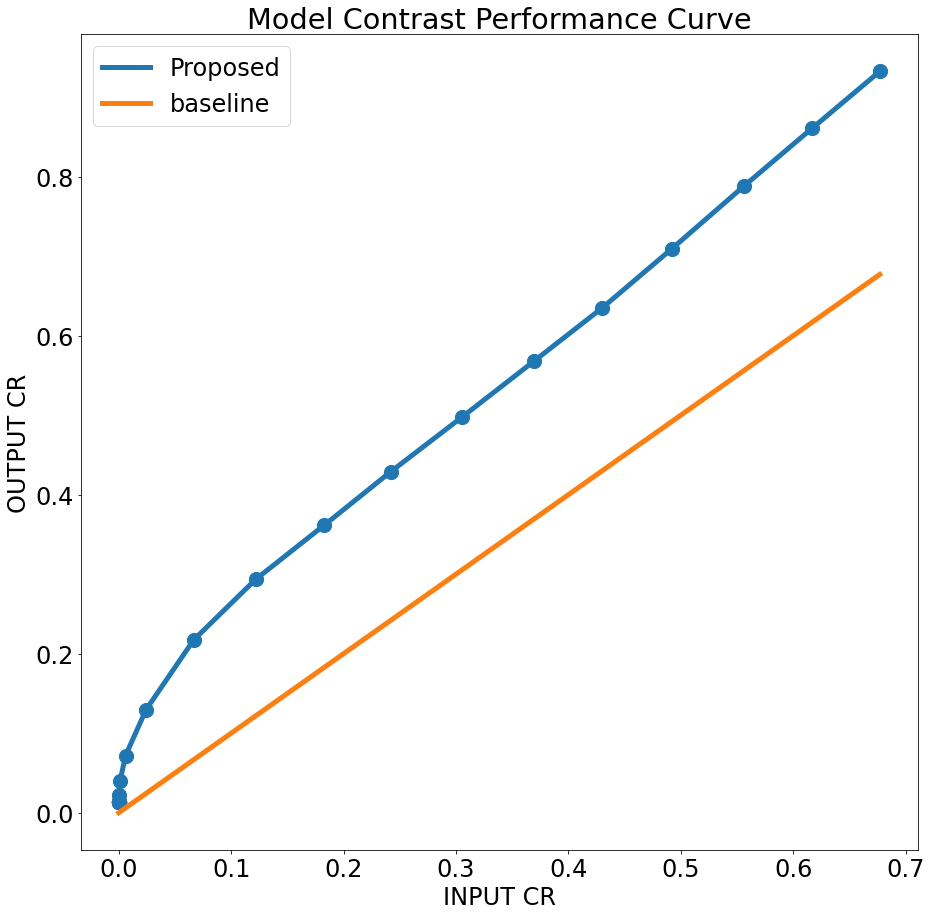

In [7]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 24})
plt.figure(1)
plt.scatter(input_CR,output_CR, s=200)
plt.plot(input_CR,output_CR, label='Proposed', linewidth=5)
plt.plot(input_CR,input_CR, label='baseline',  linewidth=5)
plt.xlabel('INPUT CR')
plt.ylabel('OUTPUT CR')
plt.title('Model Contrast Performance Curve')
plt.legend()
plt.savefig('model_noise_curve.png',dpi=(300), bbox_inches='tight')
# plt.close()

Comparison of input V/S output image

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'Simulation Phantom image')

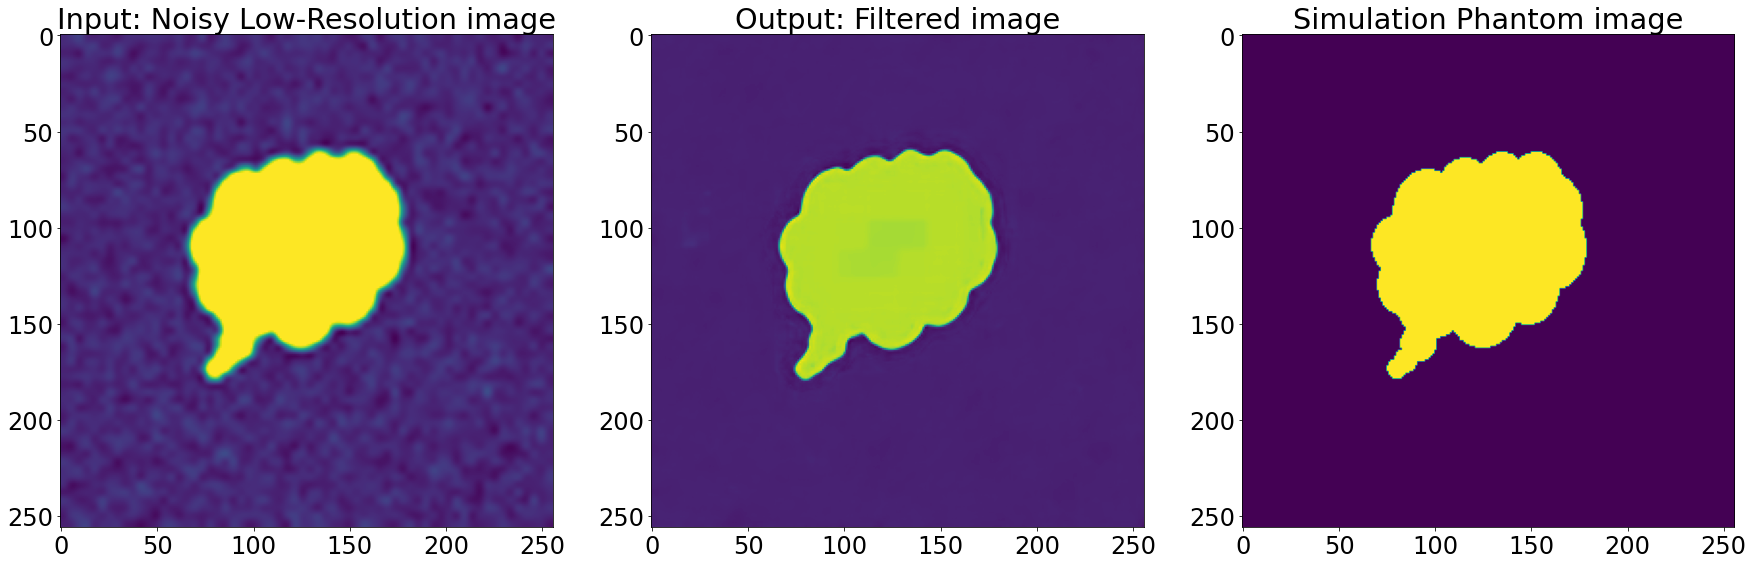

In [8]:
label_img, input_img, output_img = prepare_sample(input_file,noise_level=0.2,blur_level=0.8)

plt.rcParams["figure.figsize"] = (30,30)
plt.rcParams.update({'font.size': 24})
plt.figure(2)
plt.subplot(1,3,1)
plt.imshow(input_img.squeeze())
plt.title('Input: Noisy Low-Resolution image')
plt.subplot(1,3,2)
plt.imshow(output_img.squeeze())
plt.title('Output: Filtered image')
plt.subplot(1,3,3)
plt.imshow(label_img.squeeze())
plt.title('Simulation Phantom image')